### Summary
- [Import library](#Import-library)
- [Load csv](#Load-csv)
- [Read dataset](#Read-dataset)
- [Filter of dataset](#Filter-of-dataset)

- [RQ1](#RQ1)
    - [Project size filter](#Project-size-filter)
    - [Number of projects per size](#Number-of-projects-per-size)
        - [Size of Ruby and Java projects](#Size-of-Ruby-and-Java-projects)
    - [Frequency per day and month](#Frequency-per-day-and-month)
    - [Plot in bar](#Plot-in-bar)
    - [Plot size of all projects](#Plot-size-of-all-projects)
    - [Data from very small projects, small, medium, large and very large.](#Data-from-very-small-projects,-small,-medium,-large-and-very-large)
    - [General media of commits](#General-media-of-commits)
    - [Number of projects below average](#Number-of-projects-below-average)
    - [Description of java projects](#Description-of-java-projects)
    - [Description of ruby projects](#Description-of-ruby-projects)
    - [Plot of java project commits frequency](#Plot-of-java-project-commits-frequency)
    - [Plot of ruby project commits frequency](#Plot-of-ruby-project-commits-frequency)

- [RQ2](#RQ2)
    - [Number of builds per java project](#Number-of-builds-per-java-project)
    - [Receive java projects that use coveralls](#Receive-java-projects-that-use-coveralls)
    - [Number of builds per ruby project](#Number-of-builds-per-ruby-project)
    - [Receive java projects that use coveralls](#Receive-ruby-projects-that-use-coveralls)
    - [Coverralls dataset with filters - Java](#Coverralls-dataset-with-filters---Java)
    - [Travis dataset with filters - Java](#Travis-dataset-with-filters---Java)
    - [Coverralls dataset with filters - Ruby](#Coverralls-dataset-with-filters---Ruby)
    - [Travis dataset with filters - Ruby](#Travis-dataset-with-filters---Ruby)
    - [Boxplot](#Boxplot)
    - [Comparing](#Comparing)
    - [Get coveralls data](#Get-coveralls-data)
    - [Calculate some statistic util informations](#Calculate-some-statistic-util-informations)

- [RQ3](#RQ3)
    - [Filters the Java language and returns a list with the name of the projects](#Filters-the-Java-language-and-returns-a-list-with-the-name-of-the-projects)
    - [Creates 2 filters for passing and non-passing builds](#Creates-2-filters-for-passing-and-non-passing-builds)
    - [Creates a list with the amount builds passed and failed](#Creates-a-list-with-the-amount-builds-passed-and-failed)
    - [Status Build](#Status-Build)
    - [Status Build for all projects](#Status-Build-for-all-projects)
    - [Status build for JAVA](#Status-build-for-JAVA)
    - [Status build for RUBY](#Status-build-for-RUBY)
    - [Number of projects](#Number-of-projects)
    - [Number of projects with broken build](#Number-of-projects-with-broken-build)
    - [Displays build broken by language](#Displays-build-broken-by-language)

- [RQ4](#RQ4)
    - [Filter dataset](#Filter-dataset)
    - [Amount of build less than 10 minutes and more than 10 minutes](#Amount-of-build-less-than-10-minutes-and-more-than-10-minutes)
    - [Duration build for projetc Very small, small, medium, large and very large](#Duration-build-for-projetc-Very-small,-small,-medium,-large-and-very-large)
    - [Project size by language type](#Project-size-by-language-type)
    - [Filter language Java](#Filter-language-Java)
        - [Java build quantity less than 10 minutes and more than 10 minutes](#Java-build-quantity-less-than-10-minutes-and-more-than-10-minutes)
        - [Projects java, Very small, small, medium, large and very large](#Projects-java,-Very-small,-small,-medium,-large-and-very-large)
    - [Filter language Ruby](#Filter-language-Ruby)
        - [Ruby build quantity less than 10 minutes and more than 10 minutes](#Ruby-build-quantity-less-than-10-minutes-and-more-than-10-minutes)
    - [Projects ruby Very small, small, medium, large e very large](#Projects-ruby-Very-small,-small,-medium,-large-e-very-large)

# Import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import csv
import datetime

import requests
import math
import csv
import re

# Load csv

In [4]:
FILE = '~ci-analysis/travistorrent_11_1_2017.csv.gz'

# Read dataset

In [5]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'gh_is_pr',
                                                         'gh_pr_created_at',
                                                         'gh_lang',
                                                         'git_branch',
                                                         'gh_num_commits_in_push',
                                                         'git_prev_commit_resolution_status',
                                                         'tr_prev_build',
                                                         'gh_first_commit_created_at',
                                                         'gh_team_size',         
                                                         'gh_pushed_at',
                                                         'gh_sloc',
                                                         'tr_log_bool_tests_failed',
                                                         'tr_log_setup_time',
                                                         'tr_log_buildduration',
                                                         'tr_status'],dtype={ 'tr_build_id': np.float32,
                                                                                            'gh_project_name': 'category',
                                                                                            'gh_is_pr': np.bool,
                                                                                            'gh_pr_created_at': 'category',
                                                                                            'gh_lang': 'category',
                                                                                            'git_branch': 'category',
                                                                                            'gh_num_commits_in_push': np.float32,
                                                                                            'git_prev_commit_resolution_status': 'category',
                                                                                            'tr_prev_build': np.float32,
                                                                                            'gh_first_commit_created_at': 'category',
                                                                                            'gh_team_size': np.int32,
                                                                                            'gh_pushed_at': 'category',                                                                                           
                                                                                            'gh_sloc': np.int32}, encoding='utf-8')


# Filter of dataset 

In [6]:
dataset = dataset.loc[dataset['git_branch'] == 'master'] #filter only projects in the master
dataset = dataset[dataset.gh_lang != 'javascript'] #remove projects java script
dataset = dataset.dropna(subset=['gh_num_commits_in_push']) #remove NaN in the column specified
dataset['gh_pushed_at'] = pd.to_datetime(dataset.gh_pushed_at) #transforms for datetime
dataset = dataset.drop_duplicates(['tr_build_id']) #remove duplicates

# RQ1

### Project size filter

In [7]:
"""
Design below 1,000 lines will be discarded, project owning above 1000 and less than 10,000 will be considered small,
projects owning over 10,000 lines and less than 100,000 will be considered medium and projects above 100,000 
lines will be considered large
"""
def size_project(dataset, language, sett):
    dataset = dataset.sort_values(['gh_sloc'], ascending=False)
    if(sett == 1): #abaixo de 1000 linhas
        df1 = dataset.loc[(dataset['gh_sloc'] < 1000) & (dataset['gh_lang'] == language)]
        ##list_project_df1 = df1.gh_project_name.unique().tolist()
        #print("Projetos {} abaixo de 1000 linhas: {}".format(language, len(list_project_df1)))  
        return(df1)
    if(sett == 2): #acima de 1000 e menos que 10.000
        df2 = dataset.loc[(dataset['gh_sloc'] < 10000)]
        df2 = df2.loc[(df2['gh_sloc'] > 1000) & (df2['gh_lang'] == language)]
        #list_project_df2 = df2.gh_project_name.unique().tolist() #filtra o nome de cada projeto e coloca em uma lista
        
        #print("Projetos {} acima de 1000 linhas e abaixo de 10.000 : {}".format(language,len(list_project_df2)))
        return(df2)
    
    if(sett == 3): #acima de 10.000 linhas e menos que 100.000
        df3 = dataset.loc[(dataset['gh_sloc'] < 100000)]
        df3 = df3.loc[(df3['gh_sloc'] > 10000) & (df3['gh_lang'] == language)]
        #list_project_df3 = df3.gh_project_name.unique().tolist() #filtra o nome de cada projeto e coloca em uma lista
    
        #print("Projetos {} acima de 10.000 linhas e abaixo de 100.000 : {}".format(language,len(list_project_df3)))
        return(df3)
    
    if(sett == 4): #acima de 100.000 linhas
        df4 = dataset.loc[(dataset['gh_sloc'] > 100000) & (dataset['gh_lang'] == language)]
        #list_project_df4 = df4.gh_project_name.unique().tolist() #filtra o nome de cada projeto e coloca em uma lista
    
        #print("Projetos {} acima de 100.000 linhas: {}".format(language,len(list_project_df4)))
        return(df4)        

### Number of projects per size

In [8]:
# modelo parcial, ainda falta retornar um dataset 
# project sizes per line
def quantidade_projetos_all(language, sett):
    small, medium, large, project_null, very_large = 0,0,0,0,0
    
    df = dataset.sort_values(['gh_sloc'], ascending=False)
    df = df.loc[df['gh_lang'] == language]
    
    list_name_project = df.gh_project_name.unique().tolist()

    if(sett == 1):
        for name in list_name_project:
            df0 = df.loc[df['gh_project_name'] == name]
            if(1000 > df0.gh_sloc[0:1].item()):
                project_null +=1
        print("Projetos {} abaixo de 1000 linhas: {}".format(language, project_null)) 
        
    if(sett == 2):
        for name in list_name_project:
            df1 = df.loc[df['gh_project_name'] == name]
            if((1000 < df1.gh_sloc[0:1].item()) and (10000 > df1.gh_sloc[0:1].item())):
                small +=1
        print("Projetos {} acima de 1000 linhas e abaixo de 10.000 : {}".format(language, small))
        
    if(sett == 3):
        for name in list_name_project:
            df2 = df.loc[df['gh_project_name'] == name]
            if((10000 < df2.gh_sloc[0:1].item()) and (100000 > df2.gh_sloc[0:1].item())):
                medium +=1
        print("Projetos {} acima de 10.000 linhas e abaixo de 100.000 : {}".format(language,medium))
        
    if(sett == 4):
        for name in list_name_project:
            df3 = df.loc[df['gh_project_name'] == name]
            if((100000 < df3.gh_sloc[0:1].item()) and (1000000 > df3.gh_sloc[0:1].item())):
                large +=1
        print("Projetos {} acima de 100.000 linhas e abaixo de 1.000.000: {}".format(language,large))
        
    if(sett == 5):
        for name in list_name_project:
            df4 = df.loc[df['gh_project_name'] == name]
            if(1000000 <= df4.gh_sloc[0:1].item()):
                very_large +=1
        print("Projetos {} acima de 1.000.000 linhas: {}".format(language, very_large))

### Size of Ruby and Java projects

In [9]:
# tirar o comentado do metodo para não haver erro
quantidade_projetos_all('ruby', 1)
quantidade_projetos_all('ruby', 2)
quantidade_projetos_all('ruby', 3)
quantidade_projetos_all('ruby', 4)
quantidade_projetos_all('ruby', 5)

print("\n")

quantidade_projetos_all('java', 1)
quantidade_projetos_all('java', 2)
quantidade_projetos_all('java', 3)
quantidade_projetos_all('java', 4)
quantidade_projetos_all('java', 5)

Projetos ruby abaixo de 1000 linhas: 322
Projetos ruby acima de 1000 linhas e abaixo de 10.000 : 471
Projetos ruby acima de 10.000 linhas e abaixo de 100.000 : 76
Projetos ruby acima de 100.000 linhas e abaixo de 1.000.000: 8
Projetos ruby acima de 1.000.000 linhas: 0


Projetos java abaixo de 1000 linhas: 14
Projetos java acima de 1000 linhas e abaixo de 10.000 : 151
Projetos java acima de 10.000 linhas e abaixo de 100.000 : 185
Projetos java acima de 100.000 linhas e abaixo de 1.000.000: 27
Projetos java acima de 1.000.000 linhas: 1


### Frequency per day and month

In [10]:
def weekday_frequency(dataframe): #weekday
    
    dataframe = dataframe.gh_pushed_at.dt.weekday

    monday  = []
    tuesday  = []
    wednesday = []
    thursday  = []
    friday = []
    saturday = []
    sunday = []

    for date in dataframe:
        if(date == 0):
            monday.append(date)
        elif(date == 1):
            tuesday.append(date)
        elif(date == 2):
            wednesday.append(date)
        elif(date == 3):
            thursday.append(date)
        elif(date == 4):
            friday.append(date)
        elif(date == 5):
            saturday.append(date)
        elif(date == 6):
            sunday.append(date)
            
    #print("\nMonday: {} commits \n Tuesday: {} \n wednesday: {} \n Thursday: {} \n Friday: {} \n Saturday: {}\n Sunday: {}".format(len(monday), len(tuesday), len(wednesday), len(thursday), len(friday), len(saturday), len(sunday)))
      
    return([monday, tuesday, wednesday, thursday, friday, saturday, sunday])

### Plot in bar

In [11]:
def plot_bar(sett, language, very_small,low, medium, high):
    
    # Dados do grafico
    if(sett == 0):
        frequency_low = [len(low[0]),len(low[1]),len(low[2]),len(low[3]),len(low[4]),len(low[5]),len(low[6]),len(low[7]),len(low[8]),len(low[9]),len(low[10]),len(low[11])]
        frequency_medium = [len(medium[0]),len(medium[1]),len(medium[2]),len(medium[3]),len(medium[4]),len(medium[5]),len(medium[6]),len(medium[7]),len(medium[8]),len(medium[9]),len(medium[10]),len(medium[11])]
        frequency_high = [len(high[0]),len(high[1]),len(high[2]),len(high[3]),len(high[4]),len(high[5]),len(high[6]),len(high[7]),len(high[8]),len(high[9]),len(high[10]),len(high[11])]

        labels_list = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
    if(sett == 1):
        frequency_very_small = [len(very_small[0]),len(very_small[1]),len(very_small[2]),len(very_small[3]),len(very_small[4]),len(very_small[5]),len(very_small[6])]
        frequency_low = [len(low[0]),len(low[1]),len(low[2]),len(low[3]),len(low[4]),len(low[5]),len(low[6])]
        frequency_medium = [len(medium[0]),len(medium[1]),len(medium[2]),len(medium[3]),len(medium[4]),len(medium[5]),len(medium[6])]
        frequency_high = [len(high[0]),len(high[1]),len(high[2]),len(high[3]),len(high[4]),len(high[5]),len(high[6])]

        labels_list = ['Monday', 'Tuesday','wednesday','thursday ','friday','saturday','sunday']
        
    # Largura das barras
    barWidth = 0.20
    
    # Tamanho do Grafico
    plt.figure(figsize=(10,9))
    
    # Posicao da barras
    r1 = np.arange(len(frequency_very_small))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    
    
    # Criando as barras
    plt.bar(r1, frequency_very_small, color='#303F9F', width=barWidth, label='Very Small')
    plt.bar(r2, frequency_low, color='#03A9F4', width=barWidth, label='Small')
    plt.bar(r3, frequency_medium, color='#3F51B5', width=barWidth, label='Medium')
    plt.bar(r4, frequency_high, color='#212121', width=barWidth, label='Large')
    
    # Adicionando legendas as barras
    if(sett == 0):
        plt.xlabel('Months', fontsize=15)
    if(sett == 1):
        plt.xlabel('Weekday', fontsize=15)
   
    plt.xticks([r + barWidth for r in  range(len(frequency_low))], labels_list)
    plt.ylabel('Quantity of commits', fontsize=15)
    plt.title('{}'.format(language), fontsize=15)
    
    
    plt.legend()
    plt.savefig('frequencia_por_dia_semana.eps', format='eps')
    plt.show()
  

### Plot size of all projects

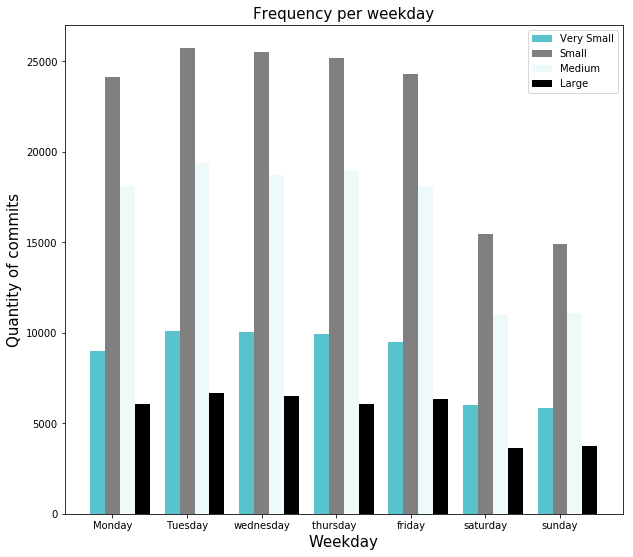

In [12]:
def project(sett):
    #dataset = dataset.sort_values(['gh_sloc'], ascending=False)
    if(sett == 1): #abaixo de 1000 linhas
        df1 = dataset.loc[dataset['gh_sloc'] < 1000]
        return(df1)
    
    if(sett == 2): #acima de 1000 e menos que 10.000
        df2 = dataset.loc[dataset['gh_sloc'] < 10000]
        df2 = df2.loc[df2['gh_sloc'] > 1000]
        return(df2)
    
    if(sett == 3): #acima de 10.000 linhas e menos que 100.000
        df3 = dataset.loc[dataset['gh_sloc'] < 100000]
        df3 = df3.loc[df3['gh_sloc'] > 10000]
        return(df3)
    
    if(sett == 4): #acima de 100.000 linhas
        df4 = dataset.loc[dataset['gh_sloc'] > 100000]
        return(df4)        
    
df_very_small = project(1)

df_small = project(2)

df_medium = project(3)

df_large = project(4)


weekday_very_small = weekday_frequency(df_very_small)
weekday_small = weekday_frequency(df_small)
weekday_medium = weekday_frequency(df_medium)
weekday_large = weekday_frequency(df_large)

plot_bar(1, 'Frequency per weekday', weekday_very_small, weekday_small, weekday_medium, weekday_large)

### Data from very small projects, small, medium, large and very large.

In [21]:
#abaixo de 1000
df_very_small = dataset.loc[(dataset['gh_sloc'] < 1000)]

#acima de 1000 e menos que 10.000
df_small = dataset.loc[(dataset['gh_sloc'] < 10000)]
df_small = df_small.loc[(df_small['gh_sloc'] > 1000)]

#acima de 10.000 linhas e menos que 100.000
df_medium = dataset.loc[(dataset['gh_sloc'] < 100000)]
df_medium = df_medium.loc[(df_medium['gh_sloc'] > 10000)]

#acima de 100.000 linhas e menos que 1.000.000
df_large = dataset.loc[(dataset['gh_sloc'] > 100000)]
df_large = df_large.loc[df_large['gh_sloc'] < 1000000]

df_very_large = dataset.loc[dataset['gh_sloc'] > 1000000]

# print("\n\nMédia e desvio padrão dos projetos muito pequenos\n", df_very_small.gh_num_commits_in_push.describe(),"\nmedian:", df_very_small.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos pequenos\n", df_small.gh_num_commits_in_push.describe(), "\nmedian:", df_small.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos medios\n", df_medium.gh_num_commits_in_push.describe(), "\nmedian:",df_medium.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos grandes\n", df_large.gh_num_commits_in_push.describe(), "\nmedian:",df_large.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos muito grandes\n", df_very_large.gh_num_commits_in_push.describe(), "\nmedian:",df_very_large.gh_num_commits_in_push.median())

### General media of commits

In [33]:
dataset.gh_num_commits_in_push.mean()

2.356738805770874

### Number of projects below average

In [22]:
cont=0

list_name = dataset.gh_project_name.unique().tolist()

for i in range(len(list_name)):

    df = dataset.loc[dataset['gh_project_name'] == list_name[i]]

    mean = df.gh_num_commits_in_push.mean()

    if(mean < 2.36):
        cont +=1

        
# print("Projetos com media a baixo de 2: {} ".format(len(list_name), cont))

### Description of java projects

In [23]:
df = dataset.loc[dataset['gh_lang'] == 'java']

#abaixo de 1000
df_very_small = df.loc[(df['gh_sloc'] < 1000)]

#acima de 1000 e menos que 10.000
df_small = df.loc[(df['gh_sloc'] < 10000)]
df_small = df_small.loc[(df_small['gh_sloc'] > 1000)]

#acima de 10.000 linhas e menos que 100.000
df_medium = df.loc[(df['gh_sloc'] < 100000)]
df_medium = df_medium.loc[(df_medium['gh_sloc'] > 10000)]

#acima de 100.000 linhas e menor que 1.000.000
df_large = df.loc[(df['gh_sloc'] > 100000)]
df_large = df_large.loc[df_large['gh_sloc'] < 1000000]

#acima de 1.000.000
df_very_large = df.loc[df['gh_sloc'] > 1000000]

# print("\n\nMédia e desvio padrão dos projetos muito pequenos\n", df_very_small.gh_num_commits_in_push.describe(),"\nmedian:", df_very_small.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos pequenos\n", df_small.gh_num_commits_in_push.describe(), "\nmedian:", df_small.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos medios\n", df_medium.gh_num_commits_in_push.describe(), "\nmedian:",df_medium.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos grandes\n", df_large.gh_num_commits_in_push.describe(), "\nmedia:",df_large.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos muito grandes\n", df_very_large.gh_num_commits_in_push.describe(), "\nmedian:",df_very_large.gh_num_commits_in_push.median())

### Description of ruby projects

In [24]:
df = dataset.loc[dataset['gh_lang'] == 'ruby']

#abaixo de 1000
df_very_small = df.loc[(df['gh_sloc'] < 1000)]

#acima de 1000 e menos que 10.000
df_small = df.loc[(df['gh_sloc'] < 10000)]
df_small = df_small.loc[(df_small['gh_sloc'] > 1000)]

#acima de 10.000 linhas e menos que 100.000
df_medium = df.loc[(df['gh_sloc'] < 100000)]
df_medium = df_medium.loc[(df_medium['gh_sloc'] > 10000)]

#acima de 100.000 linhas e menor que 1.000.000
df_large = df.loc[(df['gh_sloc'] > 100000)]
df_large = df_large.loc[df_large['gh_sloc'] < 1000000]

#acima de 1.000.000
df_very_large = df.loc[df['gh_sloc'] > 1000000]

# print("\n\nMédia e desvio padrão dos projetos muito pequenos\n", df_very_small.gh_num_commits_in_push.describe(),"\nmedian:", df_very_small.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos pequenos\n", df_small.gh_num_commits_in_push.describe(), "\nmedian:", df_small.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos medios\n", df_medium.gh_num_commits_in_push.describe(), "\nmedian:",df_medium.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos grandes\n", df_large.gh_num_commits_in_push.describe(), "\nmedia:",df_large.gh_num_commits_in_push.median())
# print("\n\nMédia e desvio padrão dos projetos muito grandes\n", df_very_large.gh_num_commits_in_push.describe(), "\nmedian:",df_very_large.gh_num_commits_in_push.median())

### Plot of java project commits frequency

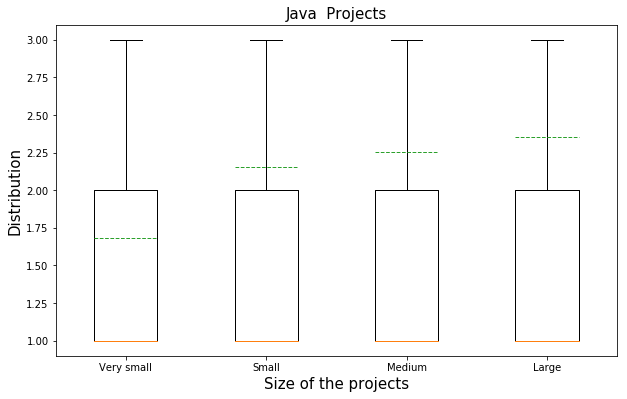

In [18]:
#abaixo de 1000
df = dataset.loc[dataset['gh_lang'] == 'java']
df = df.sort_values(['gh_sloc'], ascending=False)

df_very_small = df.loc[(df['gh_sloc'] < 1000)]

very_small = df_very_small.gh_num_commits_in_push.tolist()

#acima de 1000 e menos que 10.000
df_small = df.loc[(df['gh_sloc'] < 10000)]
df_small = df_small.loc[(df_small['gh_sloc'] > 1000)]

small = df_small.gh_num_commits_in_push.tolist()

#acima de 10.000 linhas e menos que 100.000
df_medium = df.loc[(df['gh_sloc'] < 100000)]
df_medium = df_medium.loc[(df_medium['gh_sloc'] > 10000)]

medium = df_medium.gh_num_commits_in_push.tolist()

#acima de 100.000 linhas
df_large = df.loc[(df['gh_sloc'] > 100000)]

large = df_large.gh_num_commits_in_push.tolist()



###### plot bar #######
data=[very_small, small, medium, large]

fig, ax = plt.subplots()

fig.subplots_adjust(left=0.08, right=1.38, bottom=0.05, top=1.2, hspace=0.4, wspace=0.3)
#fig.subplots_adjust(left=0.15, right=.98, bottom=0.22, top=.9, hspace=0.6, wspace=0.6)

ax.set_title('Java  Projects', fontsize=15)
ax.set_xlabel('Size of the projects', fontsize=15)
ax.set_ylabel('Distribution', fontsize=15)

ax.set_axisbelow(True)


ax.boxplot(data, 0, '', showmeans=True, meanline=True, labels=['Very small', 'Small', 'Medium', 'Large']) # boxplot sem outlier points


plt.savefig('size_project_java.eps', format='eps', dpi = 300,  bbox_inches='tight')
plt.show()

###  Plot of ruby project commits frequency

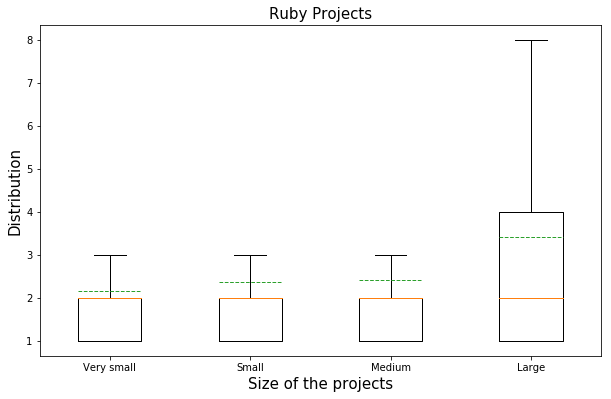

In [20]:
#abaixo de 1000
df = dataset.loc[dataset['gh_lang'] == 'ruby']
df = df.sort_values(['gh_sloc'], ascending=False)

df_very_small = df.loc[(df['gh_sloc'] < 1000)]

very_small = df_very_small.gh_num_commits_in_push.tolist()

#acima de 1000 e menos que 10.000
df_small = df.loc[(df['gh_sloc'] < 10000)]
df_small = df_small.loc[(df_small['gh_sloc'] > 1000)]

small = df_small.gh_num_commits_in_push.tolist()

#acima de 10.000 linhas e menos que 100.000
df_medium = df.loc[(df['gh_sloc'] < 100000)]
df_medium = df_medium.loc[(df_medium['gh_sloc'] > 10000)]

medium = df_medium.gh_num_commits_in_push.tolist()

#acima de 100.000 linhas
df_large = df.loc[(df['gh_sloc'] > 100000)]

large = df_large.gh_num_commits_in_push.tolist()



###### plot bar #######
data=[very_small, small, medium, large]

fig, ax = plt.subplots()

fig.subplots_adjust(left=0.08, right=1.38, bottom=0.05, top=1.2, hspace=0.4, wspace=0.3)
#fig.subplots_adjust(left=0.15, right=.98, bottom=0.22, top=.9, hspace=0.6, wspace=0.6)

ax.set_title('Ruby Projects', fontsize=15)
ax.set_xlabel('Size of the projects', fontsize=15)
ax.set_ylabel('Distribution', fontsize=15)

ax.set_axisbelow(True)


ax.boxplot(data,0,'', showmeans=True, meanline=True, labels=['Very small', 'Small', 'Medium', 'Large']) # boxplot sem outlier points


#plt.savefig('size_project_ruby.eps', format='eps', dpi = 300,  bbox_inches='tight')
plt.show()

# RQ2

### Number of builds per java project

In [64]:
df = dataset.loc[dataset['gh_lang'] == 'java']

list_name = df.gh_project_name.unique().tolist()
list_size = []

for i in range(len(list_name)):

    data = df.loc[df['gh_project_name'] == list_name[i]]

    list_size.append(data.tr_build_id.size)

    

df = pd.Series(list_size, index=list_name)

### Receive java projects that use coveralls

In [ ]:
#Receive java projects that use coveralls and then filter projects that have build in 2016
FILE = 'data/projetos_java_coverall.csv'
projetos_coverral = pd.read_csv(FILE, sep=',', engine='c')

java_coverral = projetos_coverral.gh_project_name.tolist()

projeto_java = []

for i in range(len(java_coverral)):
    project = dataset.loc[dataset['gh_project_name'] == java_coverral[i]]
    
    if(2016 == int(project.gh_pushed_at.dt.year.sort_values(ascending=False)[0:1])):
        projeto_java.append(java_coverral[i])

#cria um arquivo csv com os dados 
#output = pd.DataFrame(data=projeto_java, columns=['projetos'])
#output.to_csv('output.csv')

### Number of builds per ruby project

In [68]:
df = dataset.loc[dataset['gh_lang'] == 'ruby']

list_name = df.gh_project_name.unique().tolist()
list_size = []

for i in range(len(list_name)):

    data = df.loc[df['gh_project_name'] == list_name[i]]

    list_size.append(data.tr_build_id.size)

    

df = pd.Series(list_size, index=list_name)
#df.sort_values(ascending=False)

#cria um arquivo csv com os dados 
#output = pd.DataFrame(data=list_size, index=list_name, columns=['projetos'])
#df.to_csv('output_ruby.csv')

### Receive ruby projects that use coveralls

In [ ]:
# Recebe projetos java que usam coverrals e dps filtra os projetos que possuem build em 2016
FILE = 'data/projetos_ruby_coverall.csv'
projetos_coverral = pd.read_csv(FILE, sep=',', engine='c')


ruby_coverral = projetos_coverral.gh_project_name.tolist()

projeto_ruby = []

for i in range(len(ruby_coverral)):
    project = dataset.loc[dataset['gh_project_name'] == ruby_coverral[i]]
    
    if(2016 == int(project.gh_pushed_at.dt.year.sort_values(ascending=False)[0:1])):
        projeto_ruby.append(ruby_coverral[i])


#cria um arquivo csv com os dados 
#output = pd.DataFrame(data=projeto_ruby, columns=['projetos'])
#output.to_csv('output_ruby_filtrado.csv')

### Coverralls dataset with filters - Java

In [6]:
File = 'data/projetos_java_coverall_filtrados_2016.csv'
df = pd.read_csv(File, sep=',', engine='c')
df['gh_pushed_at'] = pd.to_datetime(df.gh_pushed_at).dt.date #le a coluna com apenas os dias
df['gh_pushed_at'] = df['gh_pushed_at'].sort_values(ascending=False) #ordena da data mais atual para mais antiga

#df = df.drop_duplicates(['gh_project_name']) #remove duplicados


list_name_cover = df.gh_project_name.unique().tolist() # lista de projetos do dataset

### Travis dataset with filters - Java

In [8]:
data = dataset.loc[dataset['gh_lang'] == 'java'] #filtra a linguagem do projeto
data = data.loc[data.gh_pushed_at.dt.year == 2016] #filtra o ano do projeto

data['gh_pushed_at'] = pd.to_datetime(data.gh_pushed_at).dt.date #deixa a coluna apenas com as datas

data['gh_pushed_at'] = data['gh_pushed_at'].sort_values(ascending=False)# ordena da data mais atual para mais antiga

"uso um dataset auxiliar para ciar uma lista de projetos que não serão usados"
dataset_aux = data

for i in range(len(list_name_cover)):
    
    dataset_aux = dataset_aux.loc[dataset_aux['gh_project_name'] != list_name_cover[i]]

    
#cria uma lista de projetos para remover
list_remove = dataset_aux.gh_project_name.unique().tolist()

# remove os projetos da lista criada
for i in range(len(list_remove)):
    data = data.loc[data['gh_project_name'] != list_remove[i]]

### Coverralls dataset with filters - Ruby

In [ ]:
File = 'data/projetos_ruby_coverall_filtrados_2016.csv'

df = pd.read_csv(File, sep=',', engine='c')
df['gh_pushed_at'] = pd.to_datetime(df.gh_pushed_at).dt.date #le a coluna com apenas os dias
df['gh_pushed_at'] = df['gh_pushed_at'].sort_values(ascending=False) #ordena da data mais atual para mais antiga

#df = df.drop_duplicates(['gh_project_name']) #remove duplicados

list_name_cover = df.gh_project_name.unique().tolist() # lista de projetos do dataset

### Travis dataset with filters - Ruby

In [42]:
data = dataset.loc[dataset['gh_lang'] == 'ruby'] #filtra a linguagem do projeto
data = data.loc[data.gh_pushed_at.dt.year == 2016] #filtra o ano do projeto

data['gh_pushed_at'] = pd.to_datetime(data.gh_pushed_at).dt.date #deixa a coluna apenas com as datas

data['gh_pushed_at'] = data['gh_pushed_at'].sort_values(ascending=False)# ordena da data mais atual para mais antiga

"uso um dataset auxiliar para ciar uma lista de projetos que não serão usados"
dataset_aux = data

for i in range(len(list_name_cover)):
    
    dataset_aux = dataset_aux.loc[dataset_aux['gh_project_name'] != list_name_cover[i]]

    
#cria uma lista de projetos para remover
list_remove = dataset_aux.gh_project_name.unique().tolist()

# remove os projetos da lista criada
for i in range(len(list_remove)):
    data = data.loc[data['gh_project_name'] != list_remove[i]]


### Boxplot

In [10]:
"""
Boxplot.

The code below has the purpose of visualizing code coverage between Java proje-
cts and Ruby projects using a boxplot.
"""

# Information about code coverage ([90.12, 80.00])
java = []
ruby = []

data = [java, ruby]

fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.boxplot(data, 0, showmeans=True, meanline=True, labels=['Java', 'Ruby'])
ax.set_title('Code Coverage', fontsize=10)
ax.set_xlabel('Languages', fontsize=10)
ax.set_ylabel('Distribution', fontsize=10)

plt.savefig('code_coverage.eps', format='eps', dpi = 300,  bbox_inches='tight')
plt.show()


### Comparing

In [11]:
"""
Comparing.

The code below has the purpose of filter data between Travis CI and Coveralls

"""

# Loading csvfiles with data
with open('java_coveralls.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    cover = list(spamreader)

with open('java_travis.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    travis = list(spamreader)

dicio = {}

for i in travis:
    for j in cover:
        if i[0] == j[0]:  # Comparing project names
            # String to datetime
            data1 = datetime.datetime.strptime(i[1], '%Y-%m-%d')
            data2 = datetime.datetime.strptime(j[3][0:10], '%Y-%m-%d')
            # Taking the difference of days
            quantidade_dias = (data1 - data2).days
            # Putting into a dict
            if 0 <= quantidade_dias <= 7:
                if j[0] not in dicio:
                    dicio[j[0]] = [j[2], j[3][0:10]]

# Export data into a csv file
for i in dicio:
    project_name = i
    coverage = dicio[i][0]
    push_date = dicio[i][1]
    with open('output.csv', 'a') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([project_name, push_date, coverage])


### Get coveralls data

In [ ]:
"""
Get coveralls data.

This code has the purpose of obtaining, through Coveralls, coverage data of the
projects that were obtained in Travis Torrent.
"""

projects = []
with open("output_ruby_filtrado.csv", "r") as csvfile:
    """
    loading csv fle with project names and put into a list, removing useless
    characters.
    """
    for line in csvfile:
        projects.append(re.sub('"|,|\n', '', line))

for project in projects:
    """
    Getting total pages
    """
    r = requests.get('https://coveralls.io/github/'+project+'.json?page=1')
    data = r.json()
    pages = math.ceil(data['total']/5) + 1

    for i in range(1, pages):
        """
        Making a get request in Coveralls and comparing branch and year informa
        tion and put the coverage information in a csv file.
        """
        r = requests.get('https://coveralls.io/github/'+project+'.json?page='+str(i))
        data = r.json()
        with open('output.csv', 'a') as outputfile:
            writer = csv.writer(outputfile)
            for j in range(0, len(data['builds'])):
                if (data['builds'][j]['branch'] == 'master' and
                    data['builds'][j]['created_at'][0:4] == '2016'):
                    writer.writerow([project, data['builds'][j]['branch'],
                                    data['builds'][j]['covered_percent'],
                                    data['builds'][j]['created_at']])


### Calculate some statistic util informations

In [ ]:
"""
Code used by calculate some statistic util informations
"""
from numpy import percentile
from numpy.random import rand

data = []

read_fl = pd.read_csv('file.csv')

data_min, data_max = read_fl.min(), read_fl.max()

# calculating quartiles
quartiles = percentile(read_fl, [25, 50, 75])

# calculating min and max
data_min, data_max = read_fl.min(), read_fl.max()

# printing
print('Min:    %.3f' % data_min)
print('Q1:     %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3:     %.3f' % quartiles[2])
print('Max:    %.3f' % data_max)


# RQ3

### Filters the Java language and returns a list with the name of the projects

In [25]:
df= dataset.loc[dataset['gh_lang'] == 'java']
list_name = df.gh_project_name.unique().tolist()

### Creates 2 filters for passing and non-passing builds

In [28]:
passed = df.loc[df['tr_status'] == 'passed']
failed = df.loc[df['tr_status'] == 'failed']

# print('Projetos Java')
# print('Total de builds que passaram {}'.format(passed.size))
# print('Total de builds que NÃO passaram {}'.format(failed.size))

### Creates a list with the amount builds passed and failed

In [27]:
passed = []
failed = []
for i in range(len(list_name)):
    project = df.loc[df['gh_project_name'] == list_name[i]] 
    _passed = project.loc[project['tr_status'] == 'passed']
    _failed = project.loc[project['tr_status'] == 'failed']
    
    passed.append(_passed.size)
    failed.append(_failed.size)

### Status Build

In [9]:
def status_build(project_name):
    #filtra o dataset pelo nome do projeto e ordena as datas do dataset
    df = dataset.loc[dataset['gh_project_name'] == project_name]
    
    df = df.sort_values(by='gh_pushed_at', ascending=False)#ordena da data mais atual para mais antiga
    
    df['gh_pushed_at'] = pd.to_datetime(df.gh_pushed_at).dt.date#le a coluna com apenas os dias
    
    date_line = df.gh_pushed_at # cria uma Serie com as datas
    status_build = df.tr_status.tolist() # cria uma lista com os status da build

    
    '''
    cont = 0

    for i in range(len(status_build)):

        if('failed' == status_build[i]):


            print(f'failed: {i} | time: {cont} | {time[i]}')
            cont += 1

        elif('passed' == status_build[i]):

            print(f'passed: {i} | time: {cont} | {time[i]}')
    '''
    
    build_red = []
    sett = 0
    
    for i in range(len(status_build)):

        if("failed" == status_build[i]):
            if(sett == 0):
                index_fail = i
                sett = 1
        if(('passed' == status_build[i]) and (sett == 1)):
                
                #print(f"{project_name} | build: fail:{index_fail} passed:{i} | linha: {i}: days: {date_line.iloc[i]} - {date_line.iloc[index_fail]} | day: {date_line.iloc[index_fail] - date_line.iloc[i]}")
                build_red.append(date_line.iloc[index_fail] - date_line.iloc[i]) # subtrai o dia que a build nao passou ate o dia que passa
                sett = 0

    return(build_red) # retorna uma lista com datas de quando deu fail ate pasar

### Status Build for all projects

In [6]:
list_name = dataset.gh_project_name.unique().tolist() 

#print(f"quantidade total de projetos {len(list_name)}")

list_days_broken = []
for i in range(len(list_name)):
    list_days_broken.append(status_build(list_name[i]))

days_broken = []
for j in range(len(list_days_broken)):
    days_broken = days_broken + list_days_broken[j]
    


days = pd.DataFrame(days_broken, columns=['date']) # cria uma

#print(days.date.dt.days.describe())


count = 0 
metric = days.date.dt.days.describe()[6] # 3 quartil 

#percorre o vetor quando ele encontra um que é equivalente ao if da break e vai para o proximo vetor que no caso seria outro projeto
for k in range(len(list_days_broken)):
    validate = 0 
    for j in range(len(list_days_broken[k])):
        if(metric <= list_days_broken[k][j].days):
            count+=1
            break
            #se uma metrica está sendo contada mais de uma ves quando ele encontar deve passar pra proxima lista e não fica na mesma 

#print(f"Quantidade de projetos com builds quebradas é de {count} tendo uma duração de {metric} dias")
   

quantidade total de projetos 1255
count    24333.000000
mean         7.857888
std         29.865811
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        924.000000
Name: date, dtype: float64
Quantidade de projetos com builds quebradas é de 1062 tendo uma duração de 4.0 dias


### Status build for JAVA

In [7]:
'''
Filtro a linguagem java, utilizo o def status_build e recebo um lista de dias que a build ficou quebrada, adiciono todos elementos em um lista e 
torno ela em uma Serie utilizo o describe para descrever a media e os quartils
pego o 3 quartil como metrica de builds com mais duração em quebra

percorro o vetor com as listas de dias quebrados e verifico quais são iguais ou maior a metrica definida e somo em um contador para cada projeto encontrado
'''
def days_briken(language, )
df = dataset.loc[dataset['gh_lang'] == 'java']

list_name = df.gh_project_name.unique().tolist() 

print(f"quantidade de projetos java {len(list_name)}")

list_days_broken = []
for i in range(len(list_name)):
    list_days_broken.append(status_build(list_name[i]))

days_broken = []
for j in range(len(list_days_broken)):
    days_broken = days_broken + list_days_broken[j]
    


days_java = pd.DataFrame(days_broken, columns=['date']) # cria uma


print(days_java.date.dt.days.describe())

metric = days_java.date.dt.days.describe()[6] # 3 quartil



count = 0 
metric = days_java.date.dt.days.describe()[6] # 3 quartil 

#percorre o vetor quando ele encontra um que é equivalente ao if da break e vai para o proximo vetor que no caso seria outro projeto
for k in range(len(list_days_broken)):
    for j in range(len(list_days_broken[k])):
        if(metric <= list_days_broken[k][j].days):
            count+=1
            break
            #uma metrica está sendo contada mais de uma ves quando ele encontar deve passar pra proxima lista e não fica na mesma 

#print(f"Quantidade de projetos java com builds quebradas é de {count} tendo uma duração de {metric} dias")
   

quantidade de projetos java 378
count    6365.000000
mean        5.824038
std        24.141328
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       522.000000
Name: date, dtype: float64
Quantidade de projetos java com builds quebradas é de 296 tendo uma duração de 3.0 dias


### Status build for RUBY

In [8]:
'''
I filter the java language, I use the def status_build and I get a list of days that the build was broken, I add all the elements in a list and
I use it to describe the media and the quartiles
I get the 3 quartile as the metric of builds with more duration in break

I run the vector with the lists of broken days and check which are equal or greater the defined metrica and somo in a counter for each project found
'''

df = dataset.loc[dataset['gh_lang'] == 'ruby']

list_name = df.gh_project_name.unique().tolist() 

#print(f"quantidade de projetos java {len(list_name)}")

list_days_broken = []
for i in range(len(list_name)):
    list_days_broken.append(status_build(list_name[i]))

days_broken_ruby = []
for j in range(len(list_days_broken)):
    days_broken_ruby = days_broken_ruby + list_days_broken[j]
    


days_ruby = pd.DataFrame(days_broken_ruby, columns=['date']) # cria uma


#print(days_ruby.date.dt.days.describe())

metric = days_ruby.date.dt.days.describe()[6] # 3 quartil



count = 0 
metric = days_ruby.date.dt.days.describe()[6] # 3 quartil 

#percorre o vetor quando ele encontra um que é equivalente ao if da break e vai para o proximo vetor que no caso seria outro projeto
for k in range(len(list_days_broken)):
    for j in range(len(list_days_broken[k])):
        if(metric <= list_days_broken[k][j].days):
            count+=1
            break
            #uma metrica está sendo contada mais de uma ves quando ele encontar deve passar pra proxima lista e não fica na mesma 

#print(f"Quantidade de projetos ruby com builds quebradas é de {count} tendo uma duração de {metric} dias")
   

quantidade de projetos java 877
count    17968.000000
mean         8.578362
std         31.615484
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        924.000000
Name: date, dtype: float64
Quantidade de projetos ruby com builds quebradas é de 776 tendo uma duração de 4.0 dias


### Number of projects

In [6]:
def quantidade_projetos(language, sett):
    small, medium, large, very_small= [], [], [], []
    
    df = dataset.sort_values(['gh_sloc'], ascending=False)
    df = df.loc[df['gh_lang'] == language]
    
    list_name_project = df.gh_project_name.unique().tolist()

    if(sett == 1):
        for name in list_name_project:
            df0 = df.loc[df['gh_project_name'] == name]
            if(1000 > df0.gh_sloc[0:1].item()):
                very_small.append(name)
        return(very_small)
       
    if(sett == 2):
        for name in list_name_project:
            df1 = df.loc[df['gh_project_name'] == name]
            if((1000 < df1.gh_sloc[0:1].item()) and (10000 > df1.gh_sloc[0:1].item())):
                small.append(name)
        return(small)
    
    if(sett == 3):
        for name in list_name_project:
            df2 = df.loc[df['gh_project_name'] == name]
            if((10000 < df2.gh_sloc[0:1].item()) and (100000 > df2.gh_sloc[0:1].item())):
                medium.append(name)
        return(medium)
    
    if(sett == 4):
        for name in list_name_project:
            df3 = df.loc[df['gh_project_name'] == name]
            if(100000 < df3.gh_sloc[0:1].item()):
                large.append(name)
        return(large)
    

### Number of projects with broken build

In [7]:
def days_broken(list_name):
    
    print(f"quantidade de projetos {len(list_name)}")


    list_days_broken = []
    for i in range(len(list_name)): #cria uma matriz de dias quebrados
        list_days_broken.append(status_build(list_name[i]))

    days_broken = []
    for j in range(len(list_days_broken)): #transforma a matriz numa lista
        days_broken = days_broken + list_days_broken[j]



    df_broken = pd.DataFrame(days_broken, columns=['date']) # cria uma


    print(df_broken.date.dt.days.describe())

    metric = df_broken.date.dt.days.describe()[6] # 3 quartil



    count = 0 
    metric = df_broken.date.dt.days.describe()[6] # 3 quartil 

    #percorre o vetor quando ele encontra um que é equivalente ao if da break e vai para o proximo vetor que no caso seria outro projeto
    for k in range(len(list_days_broken)):
        for j in range(len(list_days_broken[k])):
            if(metric <= list_days_broken[k][j].days):
                count+=1
                break
                #uma metrica está sendo contada mais de uma ves quando ele encontar deve passar pra proxima lista e não fica na mesma 

    #print(f"Quantidade de projetos com builds quebradas é de {count} tendo uma duração de {metric} dias")
   
    return(df_broken.date.dt.days)




### Displays build broken by language

In [10]:
list_very_small = quantidade_projetos('java', 1) 
very_small = days_broken(list_very_small)

list_small = quantidade_projetos('java', 2) 
small = days_broken(list_small)

list_medium = quantidade_projetos('java', 3) 
medium = days_broken(list_medium)

list_large = quantidade_projetos('java', 4) 
large = days_broken(list_large)



quantidade de projetos 14
count     81.000000
mean      20.913580
std       34.755646
min        0.000000
25%        1.000000
50%        8.000000
75%       26.000000
max      199.000000
Name: date, dtype: float64
Quantidade de projetos com builds quebradas é de 9 tendo uma duração de 26.0 dias
quantidade de projetos 151
count    1346.000000
mean        9.754086
std        31.961845
min         0.000000
25%         0.000000
50%         1.000000
75%         6.000000
max       522.000000
Name: date, dtype: float64
Quantidade de projetos com builds quebradas é de 109 tendo uma duração de 6.0 dias
quantidade de projetos 185
count    3647.000000
mean        5.107486
std        22.501392
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       511.000000
Name: date, dtype: float64
Quantidade de projetos com builds quebradas é de 143 tendo uma duração de 3.0 dias
quantidade de projetos 28
count    1291.000000
mean        2.804028
std        16.221180
min   

# RQ4

### Filter dataset

In [5]:
df = dataset
df = df.dropna(subset=['tr_log_buildduration'])
df = df.sort_values(by='tr_log_buildduration', ascending=False)

### Amount of build less than 10 minutes and more than 10 minutes

In [10]:
list_time_build = df.tr_log_buildduration.tolist()
build_10 = 0
build_long = 0


for i in list_time_build:
    if(i <= 600):
        build_10+=1
    else:
        build_long+=1
        

# print(f'Build com 10 min ou menos: {build_10}')
# print(f'Build com mais de 10 min: {build_long}')

Build com 10 min ou menos: 47998
Build com mais de 10 min: 7046


### Duration build for projetc Very small, small, medium, large and very large

In [11]:
def size_pro(sett):
    if(sett == 1): #abaixo de 1000 linhas
        df1 = dataset.loc[(dataset['gh_sloc'] < 1000)]  
        return(df1)
    if(sett == 2): #acima de 1000 e menos que 10.000
        df2 = dataset.loc[(dataset['gh_sloc'] < 10000)]
        df2 = df2.loc[(df2['gh_sloc'] > 1000) ]
        return(df2)
    
    if(sett == 3): #acima de 10.000 linhas e menos que 100.000
        df3 = dataset.loc[(dataset['gh_sloc'] < 100000)]
        df3 = df3.loc[(df3['gh_sloc'] > 10000) ]
        return(df3)
    
    if(sett == 4): #acima de 100.000 linhas
        df4 = dataset.loc[dataset['gh_sloc'] > 100000]
        df4 = df4.loc[(df4['gh_sloc'] < 1000000)]
        return(df4)
    
    if(sett == 5):
        df5 = dataset.loc[dataset['gh_sloc'] > 1000000]
        return(df5)

very_small = size_pro(1)
small = size_pro(2)
medium = size_pro(3)
large = size_pro(4)
very_large = size_pro(5)


# print(f'\nProjetos very small: \n{very_small.tr_log_buildduration.describe()} \nmediana: {very_small.tr_log_buildduration.median()}')

# print(f'\nProjetos small: \n{small.tr_log_buildduration.describe()}  \nmediana: {small.tr_log_buildduration.median()}')

# print(f'\nProjetos medium: \n{medium.tr_log_buildduration.describe()}  \nmediana: {medium.tr_log_buildduration.median()}')

# print(f'\nProjetos large: \n{large.tr_log_buildduration.describe()}  \nmediana: {large.tr_log_buildduration.median()}' )

# print(f'\nProjetos very large: \n{very_large.tr_log_buildduration.describe()}  \nmediana: {very_large.tr_log_buildduration.median()}')

### Project size by language type

In [55]:
def size_pro_lang(language,sett):
    if(sett == 1): #abaixo de 1000 linhas
        df1 = dataset.loc[(dataset['gh_sloc'] < 1000) & (dataset['gh_lang'] == language)]  
        return(df1)
    if(sett == 2): #acima de 1000 e menos que 10.000
        df2 = dataset.loc[(dataset['gh_sloc'] < 10000)]
        df2 = df2.loc[(df2['gh_sloc'] > 1000) & (df2['gh_lang'] == language)]
        return(df2)
    
    if(sett == 3): #acima de 10.000 linhas e menos que 100.000
        df3 = dataset.loc[(dataset['gh_sloc'] < 100000)]
        df3 = df3.loc[(df3['gh_sloc'] > 10000) & (df3['gh_lang'] == language)]
        return(df3)
    
    if(sett == 4): #acima de 100.000 linhas
        df4 = dataset.loc[dataset['gh_sloc'] > 100000]
        df4 = df4.loc[(df4['gh_sloc'] < 1000000) & (df4['gh_lang'] == language)]
        return(df4)
    if(sett == 5):
        df5 = df.loc[df['gh_sloc'] > 1000000]
        return()

### Filter language Java

In [58]:
df_java = df.loc[df['gh_lang'] == 'java']
# df_java.tr_log_buildduration.describe()

count    47300.000000
mean       265.856727
std        469.534484
min          0.000000
25%         20.097500
50%         84.000000
75%        271.000000
max       3589.000000
Name: tr_log_buildduration, dtype: float64

### Java build quantity less than 10 minutes and more than 10 minutes

In [59]:
list_time_build = df_java.tr_log_buildduration.tolist()
build_10 = 0
build_long = 0


for i in list_time_build:
    if(i <= 600):
        build_10+=1
    else:
        build_long+=1
        

# print(f'Build com 10 min ou menos: {build_10}')
# print(f'Build com mais de 10 min: {build_long}')

Build com 10 min ou menos: 41076
Build com mais de 10 min: 6224


### Projects java, Very small, small, medium, large and very large

In [56]:
very_small = size_pro_lang('java', 1)
small = size_pro_lang('java', 2)
medium = size_pro_lang('java', 3)
large = size_pro_lang('java', 4)
very_large = size_pro_lang('java', 5)

# print(f'\nProjetos very small: \n{very_small.tr_log_buildduration.describe()} \nmediana: {very_small.tr_log_buildduration.median()}')

# print(f'\nProjetos small: \n{small.tr_log_buildduration.describe()}  \nmediana: {small.tr_log_buildduration.median()}')

# print(f'\nProjetos medium: \n{medium.tr_log_buildduration.describe()}  \nmediana: {medium.tr_log_buildduration.median()}')

# print(f'\nProjetos large: \n{large.tr_log_buildduration.describe()}  \nmediana: {large.tr_log_buildduration.median()}' )

# print(f'\nProjetos very large: \n{very_large.tr_log_buildduration.describe()}  \nmediana: {very_large.tr_log_buildduration.median()}')

### Filter language Ruby

In [29]:
df_ruby = df.loc[df['gh_lang'] == 'ruby']
#df_ruby.tr_log_buildduration.describe()

### Ruby build quantity less than 10 minutes and more than 10 minutes

In [30]:
list_time_build = df_ruby.tr_log_buildduration.tolist()
build_10 = 0
build_long = 0


for i in list_time_build:
    if(i <= 600):
        build_10+=1
    else:
        build_long+=1
        

# print(f'Build com 10 min ou menos: {build_10}')
# print(f'Build com mais de 10 min: {build_long}')

### Projects ruby Very small, small, medium, large e very large

In [63]:
very_small = size_pro_lang('ruby', 1)
small = size_pro_lang('ruby', 2)
medium = size_pro_lang('ruby', 3)
large = size_pro_lang('ruby', 4)
very_large = size_pro_lang('ruby', 5)

print(f'\nProjetos very small: \n{very_small.tr_log_buildduration.describe()} \nmediana: {very_small.tr_log_buildduration.median()}')

print(f'\nProjetos small: \n{small.tr_log_buildduration.describe()}  \nmediana: {small.tr_log_buildduration.median()}')

print(f'\nProjetos medium: \n{medium.tr_log_buildduration.describe()}  \nmediana: {medium.tr_log_buildduration.median()}')

print(f'\nProjetos large: \n{large.tr_log_buildduration.describe()}  \nmediana: {large.tr_log_buildduration.median()}' )

print(f'\nProjetos very large: \n{very_large.tr_log_buildduration.describe()}  \nmediana: {very_large.tr_log_buildduration.median()}')